In [1]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import math

from skimage import io
from matplotlib.lines import Line2D

def quaternion_to_rotation_matrix(quaternion):
    q = np.array(quaternion, dtype=np.float64)
    norm = np.linalg.norm(q)
    if norm == 0.0:
        return np.identity(3)
    
    q /= norm
    x, y, z, w = q

    rotation_matrix = np.array([
        [1 - 2*y*y - 2*z*z, 2*x*y - 2*z*w, 2*x*z + 2*y*w],
        [2*x*y + 2*z*w, 1 - 2*x*x - 2*z*z, 2*y*z - 2*x*w],
        [2*x*z - 2*y*w, 2*y*z + 2*x*w, 1 - 2*x*x - 2*y*y]
    ])
    
    return rotation_matrix


def project(file_id):
    # Specify your folder base path
    base_path = "test"
    img_path = base_path + "/images/" + str(file_id) + ".png"
    label_path = base_path + "/labels/" + str(file_id) + ".csv"
    calib_path = base_path + "/calib/" + str(file_id) + ".csv"

    # Specify your labels so they are color matched
    colors = sns.color_palette('Paired', 9 * 2)
    names = ['box', 'man', "chair"]


    # load image
    img = np.array(io.imread(img_path), dtype=np.int32)

    # load labels
    with open(label_path, 'r') as f:
        labels = f.readlines()

    # load calibration file
    with open(calib_path, 'r') as f:
        lines = f.readlines()
        P2 = np.array(lines[0].strip().split(' '), dtype=np.float32).reshape(3, 4)
        P2 = np.array([[960.0,0,960.0,0], [0, 960.0, 540.0, 0], [0, 0, 1, 0]])

    fig = plt.figure()
    # draw image
    plt.imshow(img)

    for line in labels:
        line = line.split(" ")
        label, truncated, ocluded, x, y, z, h, w, l, qx, qy, qz, qw= line
        h, w, l, x, y, z, qw, qx, qy, qz = map(float, [h, w, l, x, y, z, qw, qx, qy, qz ])

        
        print(f"{label}: truncated: {truncated}, occluded: {ocluded}")
        x_corners = [l , l, -l , -l , l, l, -l, -l]
        y_corners = [h, h, h, h, -h, -h, -h, -h]
        z_corners = [w, -w, -w, w, w, -w, -w, w]
        corners_3d = np.vstack([x_corners, y_corners, z_corners])  # (3, 8)

        # create rotation matrix
        R = quaternion_to_rotation_matrix([qx, qy, qz, qw])
        
        # rotate the BB corners 
        corners_3d = np.dot(R, corners_3d).T + np.array([x, y, z])

        # transform the 3d bbox from camera space to screen space
        corners_3d_hom = np.concatenate((corners_3d, np.ones((8, 1))), axis=1)
        corners_img = np.matmul(corners_3d_hom, P2.T)
        corners_img = corners_img[:, :2] / abs(corners_img[:, 2][:, None])
        corners_img = np.squeeze(np.asarray(corners_img))


        def line(p1, p2, front=1):
            plt.gca().add_line(Line2D((p1[0], p2[0]), (p1[1], p2[1]), color=colors[names.index(label) * 2 + front]))


        # draw the upper 4 horizontal lines
        line(corners_img[0], corners_img[1])  # front = 0 for the front lines
        line(corners_img[1], corners_img[2])
        line(corners_img[2], corners_img[3])
        line(corners_img[3], corners_img[0],0)

        # draw the lower 4 horizontal lines
        line(corners_img[4], corners_img[5])
        line(corners_img[5], corners_img[6])
        line(corners_img[6], corners_img[7])
        line(corners_img[7], corners_img[4],0)

        # draw the 4 vertical lines
        line(corners_img[4], corners_img[0], 0)
        line(corners_img[5], corners_img[1])
        line(corners_img[6], corners_img[2])
        line(corners_img[7], corners_img[3], 0)

    # fig.patch.set_visible(False)
    plt.axis('off')
    plt.tight_layout()
    #plt.savefig('examples/kitti_3dbox_to_img.png', bbox_inches='tight')
    plt.show()



box: truncated: 1, occluded: 0
man: truncated: 0, occluded: 0


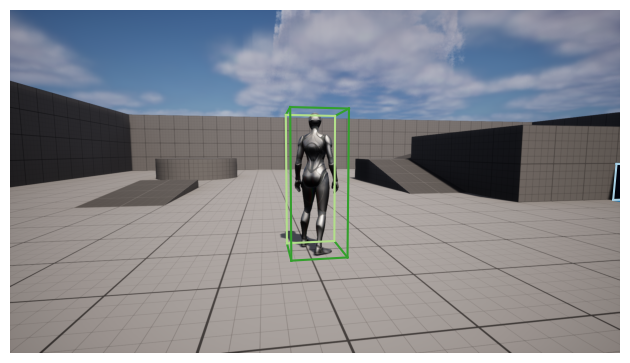

box: truncated: 1, occluded: 1
box: truncated: 0, occluded: 0
chair: truncated: 1, occluded: 0
man: truncated: 0, occluded: 0


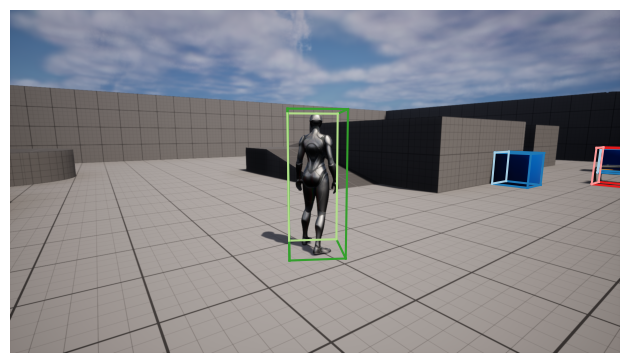

box: truncated: 0, occluded: 0
chair: truncated: 0, occluded: 2
man: truncated: 0, occluded: 0


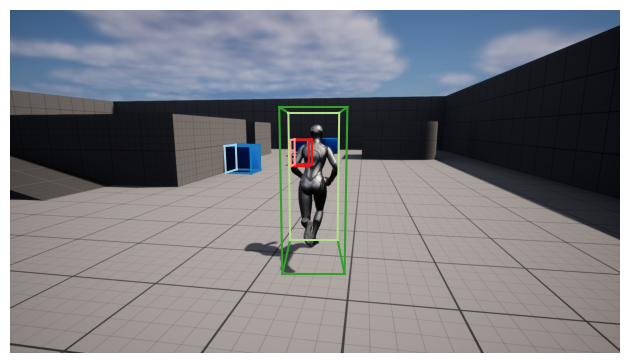

box: truncated: 0, occluded: 0
box: truncated: 0, occluded: 2
chair: truncated: 0, occluded: 0
man: truncated: 0, occluded: 0


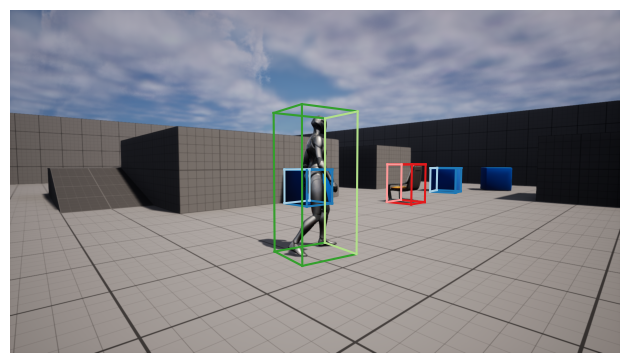

box: truncated: 0, occluded: 1
box: truncated: 0, occluded: 0
chair: truncated: 0, occluded: 0
man: truncated: 0, occluded: 0


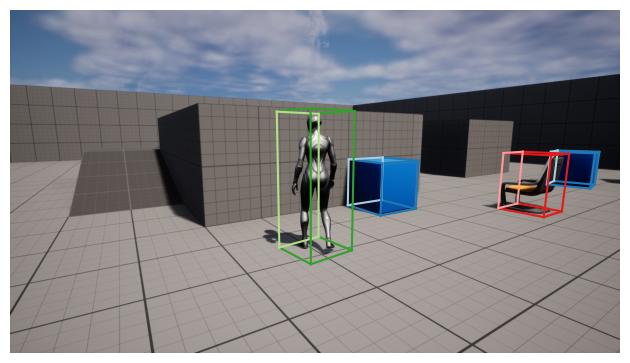

box: truncated: 0, occluded: 0
box: truncated: 0, occluded: 1
chair: truncated: 0, occluded: 0
man: truncated: 0, occluded: 0


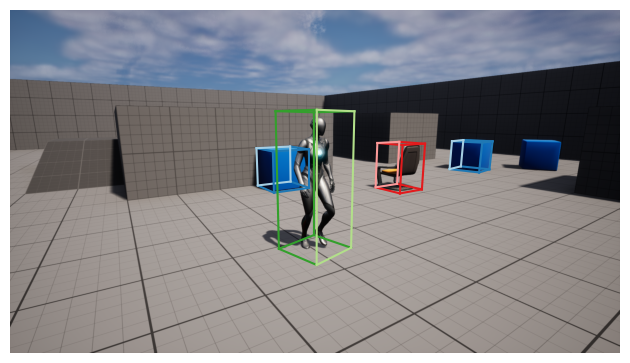

In [2]:
for i in range(0, 6):
    project(i)